In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import copy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import statsmodels.api as sm

In [390]:
np.random.seed(4)

In [391]:
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

In [392]:
# 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")
# test_df

In [393]:
# target df 읽기

columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = pd.read_csv("./data/target/event_1_day_transactions_over_100_one_sender_receive.csv")
target_event_send_df = pd.read_csv("./data/target/event_1_day_transactions_over_100_one_sender_send.csv")

target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_send_df = preprocess_transaction_flag(target_event_send_df)

target_event_receive_df.columns = columns
target_event_send_df.columns = columns

In [394]:
target_event_difference_df = target_event_receive_df.copy()
target_event_difference_df['transaction_count'] = (target_event_receive_df['transaction_count'] - target_event_send_df['transaction_count'])
target_event_difference_df['transaction_amount'] = (target_event_receive_df['transaction_amount'] - target_event_send_df['transaction_amount'])
target_event_difference_df['transaction_flag'] = target_event_difference_df['transaction_amount'].apply(
    lambda x: 1 if x > 0 else (0 if x == 0 else -1)
)
target_event_difference_df


,date,transaction_count,transaction_amount,transaction_flag
0,2017-01-01,-5492,-5.455488e+05,-1
1,2017-01-02,-7577,-1.591832e+06,-1
2,2017-01-03,-7952,-1.614416e+06,-1
3,2017-01-04,-10016,-2.999183e+06,-1
4,2017-01-05,-8695,-1.988147e+06,-1
...,...,...,...,...
2926,2025-01-05,-22,-3.607723e+04,-1
2927,2025-01-06,-25,-4.149803e+04,-1
2928,2025-01-07,-16,-2.888244e+04,-1
2929,2025-01-08,-14,-2.449558e+04,-1


In [395]:
# 날짜에 맞춰 자르기
start = (test_df['date'].values)[0]
end = (test_df['date'].values)[-1]

def trim_date(df, start, end):
    return df[(df['date']>=start) & (df['date']<=end)]

target_event_receive_df = trim_date(target_event_receive_df, start, end)
target_event_send_df = trim_date(target_event_send_df, start, end)
target_event_difference_df = trim_date(target_event_difference_df, start, end)

In [396]:
target_df = target_event_send_df

In [397]:
# target 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']

test_df['target'] = test_df['transaction_amount']

test_df = test_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag'], axis=1)
test_df.set_index('date', inplace=True)

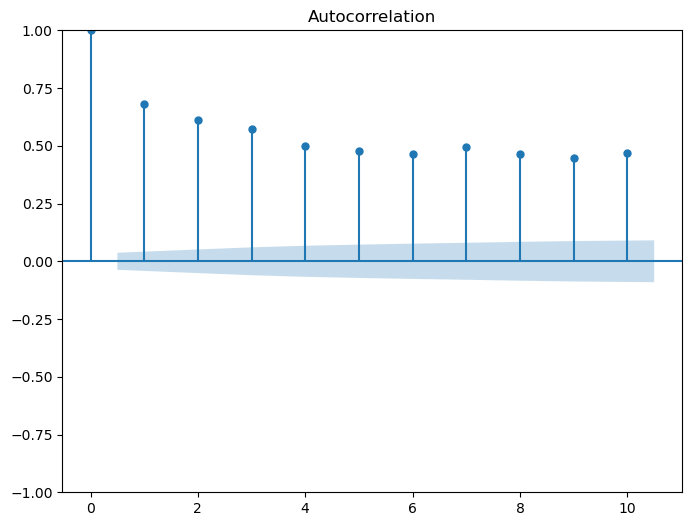

In [398]:
sm.tsa.stattools.acf(test_df['target'], nlags=10, fft=False)

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(test_df['target'], lags=10, ax=ax)
plt.show()

In [399]:
test_df = test_df.fillna(test_df.mean())

shifted_columns = test_df.columns.difference(['target'])
shifted_df = test_df[shifted_columns].shift(1)

shifted_columns = shifted_df.columns + '_shifted'
shifted_df.columns = shifted_columns

combined_df = pd.concat([shifted_df], axis=1)
combined_df['target'] = test_df['target']


In [400]:
combined_df = combined_df.dropna()
combined_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,...,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,target
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.023098,1.222708,212.466831,322474.100444,4285.08,77.428762,1.280016,0.000166,0.000185,6.625148e-09,...,5.877181e+08,604537.233636,4261.48,1.836027e+06,0.001612,3.253403e+08,83.348399,1.445047e+06,795.150377,1.726375e+06
2017-01-03,0.041238,0.944878,212.466831,97293.875547,4108.37,7.350606,0.763861,0.000166,0.000185,6.625148e-09,...,1.839618e+08,529709.000000,4285.08,1.573982e+06,-0.041238,6.822471e+06,112.884147,1.148730e+05,1199.888264,1.730227e+06
2017-01-04,0.007694,0.906574,212.466831,97444.110856,4139.98,7.415466,0.656971,0.000166,0.000185,6.625148e-09,...,1.842534e+08,515024.000000,4108.37,1.950525e+06,0.007694,8.324526e+06,117.508697,1.207600e+05,381.309763,3.193636e+06
2017-01-05,0.012969,0.986063,212.466831,97592.788943,4086.29,7.000531,0.537835,0.000166,0.000185,6.625148e-09,...,1.845561e+08,545609.000000,4139.98,2.482038e+06,-0.012969,9.340584e+06,193.337436,2.149023e+05,467.083022,2.133359e+06
2017-01-06,0.017201,0.984197,212.466831,97743.656720,4016.00,6.913398,0.355227,0.000166,0.000185,6.625148e-09,...,1.848845e+08,495910.000000,4086.29,2.998215e+06,-0.017201,2.387011e+07,114.991943,1.219580e+05,691.743060,3.183302e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.017284,1.714965,127.525725,603196.813594,63152.01,57.987881,1.280016,-0.010495,0.000057,-4.868453e-07,...,1.085537e+09,513256.000000,64262.70,8.168643e+05,-0.017284,3.253403e+08,6.648910,4.247346e+05,17813.111680,9.134364e+03
2024-09-27,0.032018,1.597736,190.793990,603443.849853,65173.99,56.629444,1.280016,0.011469,0.000090,5.319940e-07,...,1.086041e+09,515965.000000,63152.01,8.415049e+05,0.032018,3.253403e+08,8.530836,5.680784e+05,28373.305930,1.517754e+04
2024-09-28,0.009144,1.736523,61.365461,603651.398879,65769.95,63.985187,1.280016,0.007309,0.000071,3.396637e-07,...,1.086516e+09,549045.000000,65173.99,8.076291e+05,0.009144,3.253403e+08,11.071403,7.345948e+05,22048.804870,2.637931e+04


In [401]:
test_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,...,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,target
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.001612,4285.08,0.023098,795.150377,4261.48,4485.39,4200.74,284.65,17.258190,1.487585e+06,...,319896.709677,604537.233636,1.836027e+06,3.253403e+08,1.445047e+06,83.348399,4607.731346,6.700324e+05,212.466831,5.981294e+05
2017-01-02,-0.041238,4108.37,0.041238,1199.888264,4285.08,4371.52,3938.77,432.75,17.258190,1.487585e+06,...,290951.000000,529709.000000,1.573982e+06,6.822471e+06,1.148730e+05,112.884147,4607.731346,6.700324e+05,212.466831,1.726375e+06
2017-01-03,0.007694,4139.98,0.007694,381.309763,4108.37,4184.69,3850.00,334.69,17.258190,1.487585e+06,...,301664.000000,515024.000000,1.950525e+06,8.324526e+06,1.207600e+05,117.508697,4607.731346,6.700324e+05,212.466831,1.730227e+06
2017-01-04,-0.012969,4086.29,0.012969,467.083022,4139.98,4211.08,4032.62,178.46,17.258190,1.487585e+06,...,328642.000000,545609.000000,2.482038e+06,9.340584e+06,2.149023e+05,193.337436,4607.731346,6.700324e+05,212.466831,3.193636e+06
2017-01-05,-0.017201,4016.00,0.017201,691.743060,4086.29,4119.62,3911.79,207.83,17.258190,1.487585e+06,...,288501.000000,495910.000000,2.998215e+06,2.387011e+07,1.219580e+05,114.991943,4607.731346,6.700324e+05,212.466831,2.133359e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.032018,65173.99,0.032018,28373.305930,63152.01,65839.00,62670.00,3169.00,50.478391,4.361333e+06,...,474766.000000,515965.000000,8.415049e+05,3.253403e+08,5.680784e+05,8.530836,6348.207692,8.252670e+05,190.793990,9.134364e+03
2024-09-27,0.009144,65769.95,0.009144,22048.804870,65173.99,66498.00,64819.90,1678.10,40.492234,3.498529e+06,...,451723.000000,549045.000000,8.076291e+05,3.253403e+08,7.345948e+05,11.071403,6157.496350,8.435770e+05,61.365461,1.517754e+04
2024-09-28,0.001339,65858.00,0.001339,9127.233160,65769.95,66260.00,65422.23,837.77,15.528970,1.341703e+06,...,507707.000000,477266.000000,4.624474e+05,3.253403e+08,6.675219e+05,10.057609,6670.612403,8.605090e+05,75.537497,2.637931e+04


### Target의 Returns 예측

In [402]:
# 비트코인 이벤트
event_df = pd.read_csv("data/event/bitcoin_event.csv").set_index("Date")
event_df

,Event
Date,
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0
...,...
2024-12-28,0
2024-12-29,0
2024-12-30,0


In [403]:
test_df_1 = test_df.copy()
test_df_1['event_flag'] = event_df
test_df_1['event_flag'] = test_df_1['event_flag'].shift(0)

In [404]:
y = test_df_1['returns'].shift(-1).fillna(test_df_1['returns'].mean()).values
X = test_df_1[['target', 'volume', 'event_flag']].fillna(0)

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.172
Date:                Thu, 13 Feb 2025   Prob (F-statistic):             0.0238
Time:                        08:12:12   Log-Likelihood:                 1584.7
No. Observations:                 708   AIC:                            -3161.
Df Residuals:                     704   BIC:                            -3143.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001  

### XGBoost 학습

In [405]:
# 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)
scaled_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,...,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,target
0,0.058470,0.377989,0.008012,0.444296,0.015684,0.243694,0.206983,0.457019,0.079778,0.446828,...,0.446874,0.393149,0.015346,0.061314,0.639711,0.065635,0.052364,0.017250,0.000746,0.051778
1,0.104388,0.245267,0.008012,0.000000,0.013155,0.005898,0.110809,0.457019,0.079778,0.446828,...,0.000000,0.296188,0.015684,0.050474,0.570604,0.001376,0.072178,0.000829,0.001279,0.051893
2,0.019476,0.226969,0.008012,0.000296,0.013608,0.006118,0.090892,0.457019,0.079778,0.446828,...,0.000323,0.277159,0.013155,0.066050,0.649519,0.001679,0.075280,0.000902,0.000202,0.095784
3,0.032828,0.264942,0.008012,0.000590,0.012840,0.004710,0.068694,0.457019,0.079778,0.446828,...,0.000658,0.316791,0.013608,0.088036,0.616196,0.001884,0.126150,0.002064,0.000314,0.063984
4,0.043543,0.264050,0.008012,0.000887,0.011834,0.004414,0.034669,0.457019,0.079778,0.446828,...,0.001021,0.252391,0.012840,0.109388,0.609369,0.004816,0.073592,0.000916,0.000610,0.095474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,0.043751,0.613143,0.004720,0.998181,0.858044,0.177725,0.206983,0.409553,0.024584,0.443932,...,0.997856,0.274868,0.873937,0.019156,0.609237,0.065635,0.000911,0.004654,0.023139,0.000274
2825,0.081047,0.557142,0.007172,0.998669,0.886977,0.173116,0.206983,0.507340,0.038741,0.449911,...,0.998414,0.278378,0.858044,0.020175,0.688747,0.065635,0.002173,0.006424,0.037034,0.000455
2826,0.023147,0.623442,0.002156,0.999078,0.895505,0.198076,0.206983,0.488817,0.030686,0.448782,...,0.998939,0.321243,0.886977,0.018774,0.651858,0.065635,0.003877,0.008480,0.028712,0.000791
2827,0.003389,0.642072,0.002706,0.999548,0.896765,0.163456,0.206983,0.445128,0.010555,0.446109,...,0.999438,0.228233,0.895505,0.004495,0.639270,0.065635,0.003197,0.007651,0.011710,0.000324


In [406]:
y = scaled_df['target'].values
X = scaled_df.drop('target', axis=1)

In [407]:
## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [408]:
# shift 1, Linear Regression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('훈련 세트 R2 :', lr.score(X_train, y_train))

# 테스트 셋 예측
lr_y_pred = lr.predict(X_test)

# 정확도
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': lr_y_pred})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", lr.score(X_test, y_test))

훈련 세트 R2 : 0.4781303682758332
MAE: 0.09465754300915508
MSE: 0.013593704283149577
R2: -993.9356561414261


In [409]:
# 현재 모델
XGBR = XGBRegressor(n_estimators=100000, gamma=0.002, subsample=0.75, learning_rate=0.07, max_depth=3, objective='reg:squarederror')
XGBR.fit(X_train, y_train)

predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

XGBR.save_model('models/xgb_model_event_informed_amount_250211.json')

KeyboardInterrupt: 

In [ ]:
# 모델 불러오기
XGBR = XGBRegressor()
XGBR.load_model('models/xgb_model_event_informed_amount_250211.json')

# Error, R2 평가
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

MAE: 0.01347746197120829
MSE: 0.0008424734382548183
R2: -0.06715034577003998


In [285]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# import joblib

# # Create and fit the RandomForestRegressor
# # Adjust hyperparameters (n_estimators, max_depth, etc.) as needed for your problem.
# RF = RandomForestRegressor(n_estimators=30000, max_depth=3, random_state=42)
# RF.fit(X_train, y_train)

# # Generate predictions on the test set
# predict_df = pd.DataFrame({
#     'y_test': y_test,
#     'y_pred': RF.predict(X_test)
# })

# # Calculate the difference, absolute difference, and squared difference
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2

# # Print evaluation metrics
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", RF.score(X_test, y_test))

# # Save the model using joblib
# joblib.dump(RF, 'models/rf_model_event_informed_amount_250211.pkl')

# # 모델 로드
# import joblib
# import pandas as pd

# # Load the previously saved Random Forest model
# RF = joblib.load('models/rf_model_event_informed_amount_250211.pkl')

# # Evaluate the model
# predict_df = pd.DataFrame({
#     'y_test': y_test,
#     'y_pred': RF.predict(X_test)
# })
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff'] ** 2

# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", RF.score(X_test, y_test))

In [ ]:
xxx_amount = XGBR.predict(X)
test_X = copy.deepcopy(X)
test_X['ITI_amount'] = xxx_amount
test_X.index = combined_df.index
test_X

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,...,n-transactions-total_shifted,n-unique-addresses_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_amount
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.058470,0.377989,0.008012,0.444296,0.015684,0.243694,0.206983,0.457019,0.079778,0.446828,...,0.446874,0.393149,0.015346,0.061314,0.639711,0.065635,0.052364,0.017250,0.000746,0.472473
2017-01-03,0.104388,0.245267,0.008012,0.000000,0.013155,0.005898,0.110809,0.457019,0.079778,0.446828,...,0.000000,0.296188,0.015684,0.050474,0.570604,0.001376,0.072178,0.000829,0.001279,0.471767
2017-01-04,0.019476,0.226969,0.008012,0.000296,0.013608,0.006118,0.090892,0.457019,0.079778,0.446828,...,0.000323,0.277159,0.013155,0.066050,0.649519,0.001679,0.075280,0.000902,0.000202,0.470993
2017-01-05,0.032828,0.264942,0.008012,0.000590,0.012840,0.004710,0.068694,0.457019,0.079778,0.446828,...,0.000658,0.316791,0.013608,0.088036,0.616196,0.001884,0.126150,0.002064,0.000314,0.469929
2017-01-06,0.043543,0.264050,0.008012,0.000887,0.011834,0.004414,0.034669,0.457019,0.079778,0.446828,...,0.001021,0.252391,0.012840,0.109388,0.609369,0.004816,0.073592,0.000916,0.000610,0.468478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.043751,0.613143,0.004720,0.998181,0.858044,0.177725,0.206983,0.409553,0.024584,0.443932,...,0.997856,0.274868,0.873937,0.019156,0.609237,0.065635,0.000911,0.004654,0.023139,0.467577
2024-09-27,0.081047,0.557142,0.007172,0.998669,0.886977,0.173116,0.206983,0.507340,0.038741,0.449911,...,0.998414,0.278378,0.858044,0.020175,0.688747,0.065635,0.002173,0.006424,0.037034,0.467412
2024-09-28,0.023147,0.623442,0.002156,0.999078,0.895505,0.198076,0.206983,0.488817,0.030686,0.448782,...,0.998939,0.321243,0.886977,0.018774,0.651858,0.065635,0.003877,0.008480,0.028712,0.467461


In [287]:
test_X[['ITI_amount']].to_csv("data/iti/event_ITI_amount_250211.csv", index=True)

In [ ]:
ITI_amount = pd.read_csv("data/iti/event_ITI_amount_250211.csv")
ITI_amount = ITI_amount.set_index('date')
ITI_amount

,ITI_amount
date,
2017-01-02,0.472473
2017-01-03,0.471767
2017-01-04,0.470993
2017-01-05,0.469929
2017-01-06,0.468478
...,...
2024-09-26,0.467577
2024-09-27,0.467412
2024-09-28,0.467461


### 기존 Target 예측

In [289]:
# 실제 트레이딩 확인 (변수명은 그대로)
reversion_df = target_event_receive_df.copy()
reversion_df = reversion_df[['date', 'transaction_amount']]
reversion_df.columns = ['date', 'target']
reversion_df = reversion_df.set_index('date')

# 내일 target 예측
reversion_df = reversion_df.shift(-1).dropna()
reversion_df

,target
date,
2017-01-01,145062.086980
2017-01-02,128580.258129
2017-01-03,213234.378072
2017-01-04,153491.658141
2017-01-05,301741.053261
...,...
2024-09-25,15135.215905
2024-09-26,20910.848382
2024-09-27,28191.653842


In [290]:
result_df = pd.concat([ITI_amount, reversion_df], axis=1)
result_df = result_df.dropna()

In [291]:
result_df

,ITI_amount,target
date,,
2017-01-02,0.472473,128580.258129
2017-01-03,0.471767,213234.378072
2017-01-04,0.470993,153491.658141
2017-01-05,0.469929,301741.053261
2017-01-06,0.468478,401769.530813
...,...,...
2024-09-25,0.468301,15135.215905
2024-09-26,0.467577,20910.848382
2024-09-27,0.467412,28191.653842


In [292]:
y = result_df['target'].values
X = result_df['ITI_amount']

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)

In [ ]:
X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
# print("=== OLS 기본 요약 ===")
# print(lr.summary())

# 로버스트 공분산(이분산 robust: HC1) 적용
# ---------------------------------------------
lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
print("\n=== 로버스트(HC1) 요약 ===")
print(lr_hc1.summary())



=== 로버스트(HC1) 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     11.96
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           0.000572
Time:                        08:03:02   Log-Likelihood:                -10442.
No. Observations:                 849   AIC:                         2.089e+04
Df Residuals:                     847   BIC:                         2.090e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.342e+06   3.67e+

### Returns 예측

In [ ]:
test_target_df = test_df['returns'].shift(-2).dropna()


test_target_df = pd.concat([ITI_amount, test_target_df], axis=1)
test_target_df = test_target_df.dropna()

test_target_df.columns = ['ITI_amount', 'target']
test_target_df

,ITI_amount,target
date,,
2017-01-02,0.472473,-0.012969
2017-01-03,0.471767,-0.017201
2017-01-04,0.470993,0.005976
2017-01-05,0.469929,0.018319
2017-01-06,0.468478,0.049101
...,...,...
2024-09-24,0.467915,0.032018
2024-09-25,0.468301,0.009144
2024-09-26,0.467577,0.001339


In [ ]:
y = test_target_df['target'].values
X = test_target_df[['ITI_amount']]

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.139, shuffle=False, random_state=0)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
# print("=== OLS 기본 요약 ===")
# print(lr.summary())

# 로버스트 공분산(이분산 robust: HC1) 적용
# ---------------------------------------------
lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
print("\n=== 로버스트(HC1) 요약 ===")
print(lr_hc1.summary())



=== 로버스트(HC1) 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.170
Date:                Thu, 13 Feb 2025   Prob (F-statistic):              0.142
Time:                        08:03:02   Log-Likelihood:                 873.69
No. Observations:                 393   AIC:                            -1743.
Df Residuals:                     391   BIC:                            -1735.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5259      0.3

### Event 예측

In [296]:
# # 비트코인 이벤트
# event_df = pd.read_csv("data/event/bitcoin_event.csv")

In [297]:
# test_target_df = test_df['returns'].shift(-2).dropna()


# test_target_df = pd.concat([ITI_amount, test_target_df], axis=1)
# test_target_df = test_target_df.dropna()

# test_target_df.columns = ['ITI_amount', 'target']
# test_target_df

In [298]:
# test_target_receive_df = target_event_receive_df.set_index('date').copy()

In [299]:
# # 실제값 이벤트 예측용
# test_target_df['transaction_amount'] = test_target_receive_df['transaction_amount']
# test_target_df['transaction_count'] = test_target_receive_df['transaction_count']
# test_target_df['transaction_flag'] = test_target_receive_df['transaction_flag']

# test_target_df['transaction_amount'] = test_target_df['transaction_amount'].apply(lambda x: 0.000001 if x == 0 else x)
# test_target_df['transaction_amount_returns'] = test_target_df['transaction_amount'].pct_change(1).fillna(0)

In [300]:
# event_df = event_df.set_index('Date')

In [301]:
# test_target_df['event_flag'] = (event_df[(event_df.index>=list(test_target_df.index)[0])&(event_df.index<=list(test_target_df.index)[-1])]['Event'])
# test_target_df

In [302]:
# test_target_df['event_flag_lag_2'] = test_target_df['event_flag'].shift(-2).fillna(0)
# test_target_df